# Cyanobacteria Toxicity Classification Notebook with Cross-Validation

## 1. Setup & Configuration

In [1]:
import os
from datetime import date
import subprocess
import yaml
import pandas as pd
import torch
from torchvision.models import ResNet18_Weights
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision import models, datasets
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
from src.config_utils import load_config
from PIL import Image
import copy
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    brier_score_loss
)
from sklearn.calibration import calibration_curve

# Chargement de la config
config = load_config(path='../configs/config_finetune_resnet18.yaml')

# Répertoires de sortie
FIG_OUT = os.path.join('..', 'outputs', 'figures', 'Switzerland', 'finetune_resnet18')
os.makedirs(FIG_OUT, exist_ok=True)

# Génération du Run ID : date + commit Git
today = date.today().isoformat()
commit = subprocess.check_output(["git","rev-parse","--short","HEAD"]).decode().strip()
run_id = f"{today}_{commit}"

print("Run ID :", run_id)


Run ID : 2025-07-23_d94319e


## 2. Data Preparation

In [2]:
# Transforms avec RandomErasing pour dropout spatial
data_cfg = config['augmentation']

train_transform = transforms.Compose([
    transforms.Resize(tuple(data_cfg['resize'])),
    transforms.RandomHorizontalFlip() if data_cfg['horizontal_flip'] else transforms.Lambda(lambda x: x),
    transforms.RandomRotation(data_cfg['rotation']),
    transforms.ToTensor(),
    transforms.Normalize(mean=data_cfg['normalization']['mean'],
                         std=data_cfg['normalization']['std']),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random')
])

val_transform = transforms.Compose([
    transforms.Resize(tuple(data_cfg['resize'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=data_cfg['normalization']['mean'],
                         std=data_cfg['normalization']['std'])
])


In [3]:
# Chargement du dataset et Stratified K-Fold
dataset = datasets.ImageFolder(root=os.path.join('..', config['data']['path']),
                               transform=train_transform)
targets = np.array(dataset.targets)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_to_use = 0  # modifier si besoin (0 à 4)
for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets)), targets)):
    if fold == fold_to_use:
        print(f"=== Fold {fold+1} sélectionné ===")
        break

# Subsets et DataLoaders
train_subset = Subset(dataset, train_idx)
# On applique val_transform pour la validation
val_dataset_full = datasets.ImageFolder(root=os.path.join('..', config['data']['path']),
                                        transform=val_transform)
val_subset = Subset(val_dataset_full, val_idx)

train_loader = DataLoader(train_subset,
                          batch_size=config['data']['batch_size'],
                          shuffle=True,
                          num_workers=config['data']['num_workers'])
val_loader = DataLoader(val_subset,
                        batch_size=config['data']['batch_size'],
                        shuffle=False,
                        num_workers=config['data']['num_workers'])


=== Fold 1 sélectionné ===


## 3. Model Definition

In [4]:
# Définition du modèle, critère et optimizer
device = torch.device(config['training']['device'])
model = models.resnet18(weights=ResNet18_Weights.DEFAULT if config['model']['pretrained'] else None)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, config['model']['num_classes'])
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),
                       lr=float(config['training']['learning_rate']),
                       weight_decay=float(config['training']['weight_decay']))


## 4. Training Loop

In [5]:

# Boucle d'entraînement
history = {'train_loss': [], 'val_loss': []}
num_epochs = config['training']['epochs']

for epoch in range(num_epochs):
    # ---- Entraînement ----
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Train"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_train_loss = running_loss / len(train_loader.dataset)
    history['train_loss'].append(epoch_train_loss)

    # ---- Validation ----
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    history['val_loss'].append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} — Train Loss: {epoch_train_loss:.4f} — Val Loss: {epoch_val_loss:.4f}")


Epoch 1/20 - Train: 100%|██████████| 30/30 [00:53<00:00,  1.77s/it]


Epoch 1/20 — Train Loss: 0.4460 — Val Loss: 0.2844


Epoch 2/20 - Train: 100%|██████████| 30/30 [00:50<00:00,  1.69s/it]


Epoch 2/20 — Train Loss: 0.2553 — Val Loss: 0.2481


Epoch 3/20 - Train: 100%|██████████| 30/30 [00:50<00:00,  1.70s/it]


Epoch 3/20 — Train Loss: 0.1782 — Val Loss: 0.3041


Epoch 4/20 - Train: 100%|██████████| 30/30 [00:51<00:00,  1.70s/it]


Epoch 4/20 — Train Loss: 0.1702 — Val Loss: 0.3236


Epoch 5/20 - Train: 100%|██████████| 30/30 [00:50<00:00,  1.70s/it]


Epoch 5/20 — Train Loss: 0.1178 — Val Loss: 0.1196


Epoch 6/20 - Train: 100%|██████████| 30/30 [00:50<00:00,  1.69s/it]


Epoch 6/20 — Train Loss: 0.1306 — Val Loss: 0.2461


Epoch 7/20 - Train: 100%|██████████| 30/30 [00:50<00:00,  1.70s/it]


Epoch 7/20 — Train Loss: 0.1259 — Val Loss: 0.1995


Epoch 8/20 - Train: 100%|██████████| 30/30 [00:50<00:00,  1.69s/it]


Epoch 8/20 — Train Loss: 0.1266 — Val Loss: 0.1649


Epoch 9/20 - Train: 100%|██████████| 30/30 [00:51<00:00,  1.73s/it]


Epoch 9/20 — Train Loss: 0.0791 — Val Loss: 0.1700


Epoch 10/20 - Train: 100%|██████████| 30/30 [00:50<00:00,  1.69s/it]


Epoch 10/20 — Train Loss: 0.0737 — Val Loss: 0.2138


Epoch 11/20 - Train: 100%|██████████| 30/30 [00:50<00:00,  1.69s/it]


Epoch 11/20 — Train Loss: 0.0930 — Val Loss: 0.2990


Epoch 12/20 - Train: 100%|██████████| 30/30 [00:50<00:00,  1.69s/it]


Epoch 12/20 — Train Loss: 0.0761 — Val Loss: 0.2046


Epoch 13/20 - Train: 100%|██████████| 30/30 [00:50<00:00,  1.70s/it]


Epoch 13/20 — Train Loss: 0.1140 — Val Loss: 0.3076


Epoch 14/20 - Train: 100%|██████████| 30/30 [00:50<00:00,  1.70s/it]


Epoch 14/20 — Train Loss: 0.0631 — Val Loss: 0.2275


Epoch 15/20 - Train: 100%|██████████| 30/30 [00:50<00:00,  1.70s/it]


Epoch 15/20 — Train Loss: 0.0537 — Val Loss: 0.2465


Epoch 16/20 - Train: 100%|██████████| 30/30 [00:50<00:00,  1.69s/it]


Epoch 16/20 — Train Loss: 0.0471 — Val Loss: 0.3572


Epoch 17/20 - Train: 100%|██████████| 30/30 [00:50<00:00,  1.70s/it]


Epoch 17/20 — Train Loss: 0.0480 — Val Loss: 0.3546


Epoch 18/20 - Train: 100%|██████████| 30/30 [00:50<00:00,  1.69s/it]


Epoch 18/20 — Train Loss: 0.0556 — Val Loss: 0.2527


Epoch 19/20 - Train: 100%|██████████| 30/30 [00:50<00:00,  1.70s/it]


Epoch 19/20 — Train Loss: 0.0956 — Val Loss: 0.3381


Epoch 20/20 - Train: 100%|██████████| 30/30 [00:51<00:00,  1.71s/it]


Epoch 20/20 — Train Loss: 0.0968 — Val Loss: 0.9075


## 5. Results Visualization

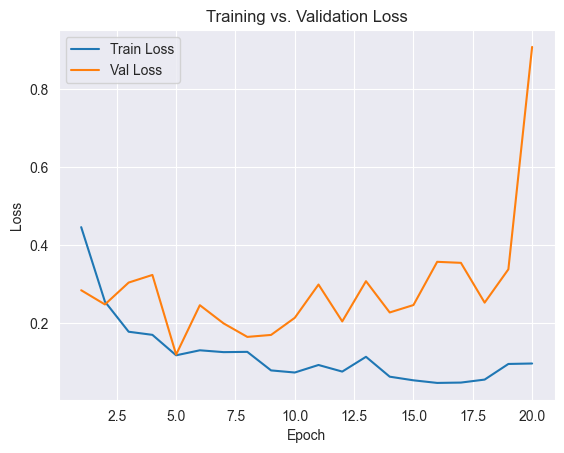

In [6]:
# Cellule 6

# Affichage des courbes de perte
epochs = np.arange(1, num_epochs + 1)

plt.figure()
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.savefig(os.path.join(FIG_OUT, f"{run_id}_loss_curve.png"), dpi=300)
plt.show()


In [7]:
# Cellule 7

# Collecte des vraies étiquettes et des probabilités sur la validation
model.eval()
y_true = []
y_prob = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = nn.functional.softmax(outputs, dim=1)[:, 1]
        y_prob.extend(probs.cpu().numpy())
        y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_prob = np.array(y_prob)


In [8]:
# Cellule 8

# Seuil optimisé à partir de la PR-curve (max F1)
precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Seuil optimal (PR-curve) : {best_threshold:.4f} — F1 : {f1_scores[best_idx]:.4f}")


Seuil optimal (PR-curve) : 0.9772 — F1 : 0.9180


ROC AUC : 0.9532 — Average Precision (AP) : 0.9348


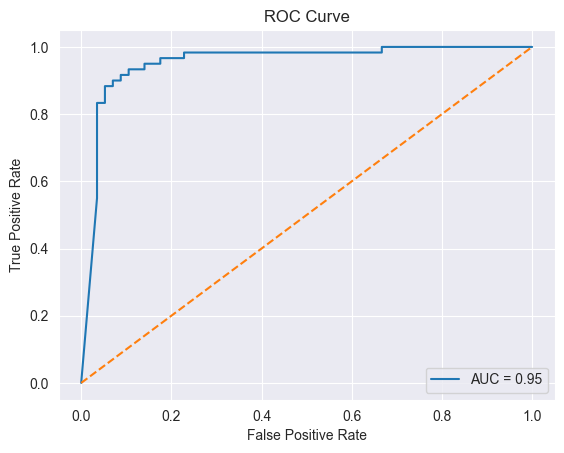

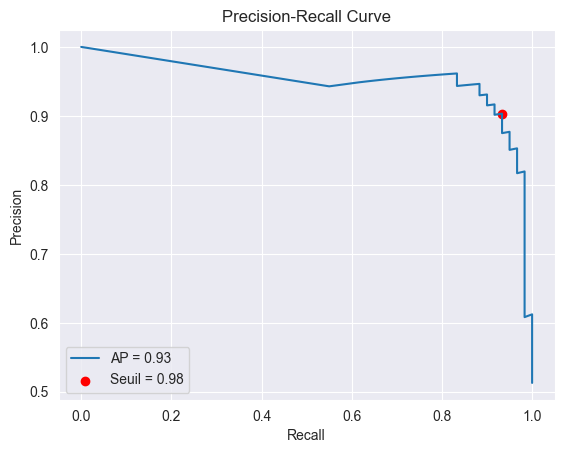

In [9]:
# Cellule 9

# Calcul des métriques et tracé ROC / PR
y_pred = (y_prob >= best_threshold).astype(int)

# Matrices et scores
cm = confusion_matrix(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_prob)
ap = average_precision_score(y_true, y_prob)

print(f"ROC AUC : {roc_auc:.4f} — Average Precision (AP) : {ap:.4f}")

# ROC
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.savefig(os.path.join(FIG_OUT, f"{run_id}_roc_curve.png"), dpi=300)
plt.show()

# PR
plt.figure()
plt.plot(recall, precision, label=f'AP = {ap:.2f}')
plt.scatter(recall[best_idx], precision[best_idx], color='red',
            label=f'Seuil = {best_threshold:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.savefig(os.path.join(FIG_OUT, f"{run_id}_pr_curve.png"), dpi=300)
plt.show()


In [10]:
# Cellule 10

# Calibration + Brier score
prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)
brier = brier_score_loss(y_true, y_prob)
print(f"Brier score : {brier:.4f}")


Brier score : 0.1404


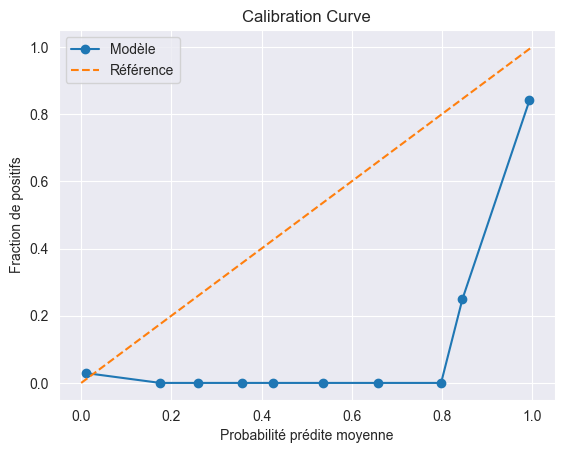

In [11]:
# Cellule 11

# Tracé de la calibration curve
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', label='Modèle')
plt.plot([0,1], [0,1], '--', label='Référence')
plt.xlabel('Probabilité prédite moyenne')
plt.ylabel('Fraction de positifs')
plt.title('Calibration Curve')
plt.legend()
plt.savefig(os.path.join(FIG_OUT, f"{run_id}_calibration_curve.png"), dpi=300)
plt.show()


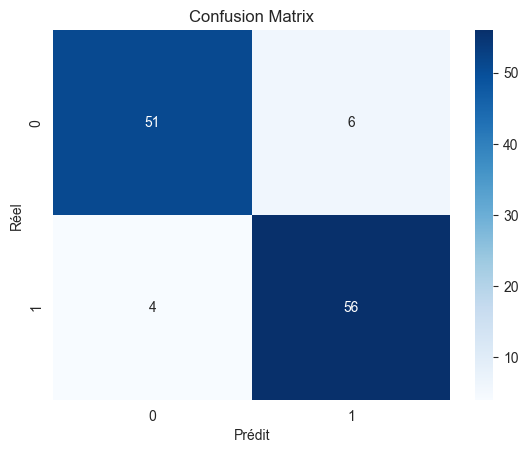

In [12]:
# Cellule 12

# Matrice de confusion (heatmap)
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(FIG_OUT, f"{run_id}_confusion_matrix.png"), dpi=300)
plt.show()


In [13]:
# Cellule 13

# Classification report détaillé
print("Classification Report :")
print(classification_report(y_true, y_pred))


Classification Report :
              precision    recall  f1-score   support

           0       0.93      0.89      0.91        57
           1       0.90      0.93      0.92        60

    accuracy                           0.91       117
   macro avg       0.92      0.91      0.91       117
weighted avg       0.91      0.91      0.91       117



## 7. Grad-CAM Interpretability

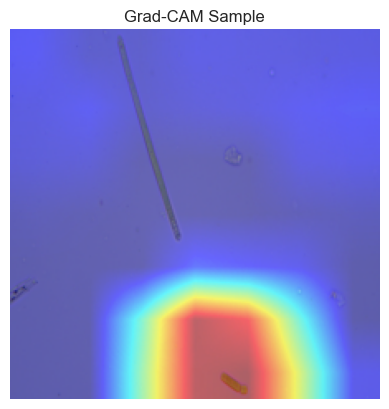

In [15]:
# Cellule 14 (corrigée) : inversion de la normalisation pour Grad-CAM

# Récupérer mean et std depuis la config
mean = data_cfg['normalization']['mean']
std  = data_cfg['normalization']['std']

def unnormalize(tensor, mean, std):
    """
    Inverse la normalisation inplace sur un tenseur C×H×W.
    """
    for c, (m, s) in enumerate(zip(mean, std)):
        tensor[c].mul_(s).add_(m)
    return tensor

# Préparer GradCAM
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

# Prendre un batch de validation
inputs_sample, _ = next(iter(val_loader))
input_tensor = inputs_sample[0].unsqueeze(0).to(device)

# Créer l'image RGB non normalisée pour l'affichage
unnorm = unnormalize(inputs_sample[0].clone(), mean, std)
rgb_img = unnorm.permute(1, 2, 0).cpu().numpy()
rgb_img = np.clip(rgb_img, 0.0, 1.0).astype(np.float32)

# Calculer et afficher le cam
grayscale_cam = cam(input_tensor=input_tensor)[0]
cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

plt.figure()
plt.imshow(cam_image)
plt.axis('off')
plt.title('Grad-CAM Sample')
plt.savefig(os.path.join(FIG_OUT, f"{run_id}_gradcam.png"), dpi=300)
plt.show()


## 6. Save Model & Config

In [16]:
# Cellule 15

# Sauvegarde du modèle et de la config
os.makedirs('../outputs/checkpoints/Switzerland/finetune_resnet18', exist_ok=True)
torch.save(model.state_dict(),
           f'../outputs/checkpoints/Switzerland/finetune_resnet18/{run_id}_model.pth')

os.makedirs('../outputs/configs/Switzerland', exist_ok=True)
with open(f'../outputs/configs/Switzerland/{run_id}_config_finetune_resnet18.yaml', 'w') as f:
    yaml.dump(config, f)

print('Entraînement terminé. Modèle et config enregistrés.')


Entraînement terminé. Modèle et config enregistrés.
